In [1]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix, coo_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def generate_many_classes(target_data):
    mlb = MultiLabelBinarizer()
    class_series = mlb.fit_transform(target_data)
    return class_series,mlb.classes_

def get_svd_score(svd_dict,b2_prod_list,row_id):
    score_list = []
    for prod in b2_prod_list:
        score_list.append(svd_dict[prod][row_id])
    return sum(score_list)

In [3]:
BASE = 'C:/Users/raghu/AMEXPERT/'
data = pd.read_csv(BASE + "train_go05W65.csv")

In [4]:
data[['Age','Vintage']].agg([min,max,np.mean,np.std])

,Age,Vintage
min,24.000000,2.000000
max,59.000000,65.000000
mean,38.521379,19.573169
std,10.121811,10.252417


In [5]:
len(data[(data['Age'] < data['Age'].quantile(0.01)) | (data['Age'] > data['Age'].quantile(0.99)) | (data['Vintage'] < data['Vintage'].quantile(0.01)) | (data['Vintage'] > data['Vintage'].quantile(0.99)) ])

830

In [6]:
(830/len(data))*100

2.1987919889795484

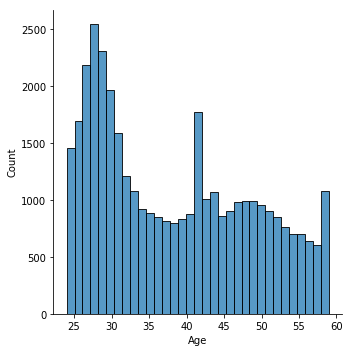

In [7]:
sns.displot(data['Age'])

In [8]:
print("Before Clipping",data['Age'].min(),data['Age'].quantile(0.01),data['Age'].quantile(.99),data['Age'].max())
data['Age'] = data['Age'].clip(lower=data['Age'].quantile(0.01),upper=data['Age'].quantile(.99))
print("After Clipping",data['Age'].min(),data['Age'].quantile(0.01),data['Age'].quantile(.99),data['Age'].max())

Before Clipping 24 25.0 59.0 59
After Clipping 25 25.0 59.0 59


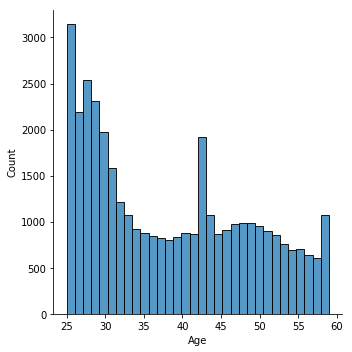

In [9]:
sns.displot(data['Age'])

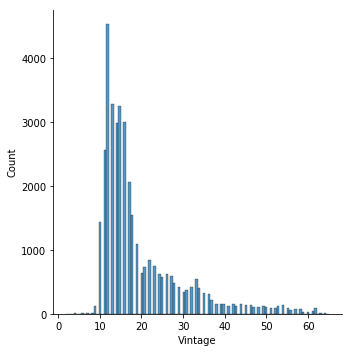

In [10]:
sns.displot(data['Vintage'])

In [11]:
print("Before Clipping",data['Vintage'].min(),data['Vintage'].quantile(0.01),data['Vintage'].quantile(.99),data['Vintage'].max())
data['Vintage'] = data['Vintage'].clip(lower=data['Vintage'].quantile(0.01),upper=data['Vintage'].quantile(.99))
print("After Clipping",data['Vintage'].min(),data['Vintage'].quantile(0.01),data['Vintage'].quantile(.99),data['Vintage'].max())

Before Clipping 2 10.0 56.0 65
After Clipping 10 10.0 56.0 56


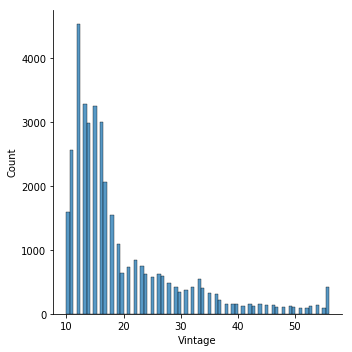

In [12]:
sns.displot(data['Vintage'])

Text(0,0.5,'Counts of Product')

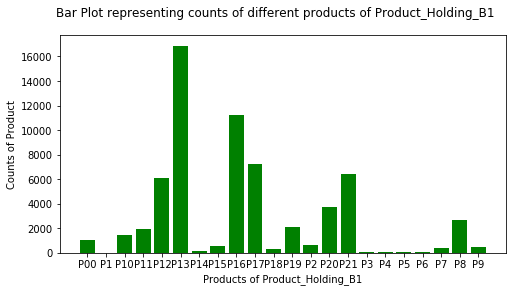

In [13]:
b1_dict = data['Product_Holding_B1'].map(lambda x : eval(x)).explode().value_counts().to_dict()
b1_dict = { k:b1_dict.get(k) for k in sorted(b1_dict) }

fig = plt.figure(figsize=(8,4))
plt.bar(b1_dict.keys(), b1_dict.values(), color='g',)
fig.suptitle('Bar Plot representing counts of different products of Product_Holding_B1')
plt.xlabel('Products of Product_Holding_B1')
plt.ylabel('Counts of Product')

Text(0,0.5,'Counts of Product')

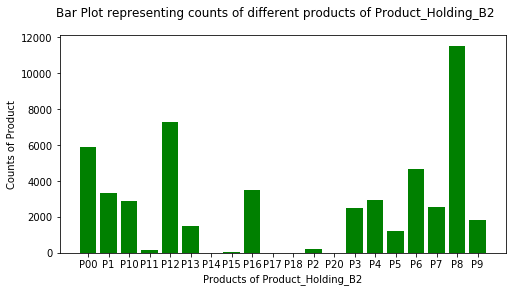

In [14]:
b2_dict = data['Product_Holding_B2'].map(lambda x : eval(x)).explode().value_counts().to_dict()
b2_dict = { k:b2_dict.get(k) for k in sorted(b2_dict) }

fig = plt.figure(figsize=(8,4))
plt.bar(b2_dict.keys(), b2_dict.values(), color='g',)
fig.suptitle('Bar Plot representing counts of different products of Product_Holding_B2')
plt.xlabel('Products of Product_Holding_B2')
plt.ylabel('Counts of Product')

In [15]:
set(b1_dict.keys()) - set(b2_dict.keys())

{'P19', 'P21'}

In [16]:
data.loc[:,'vintage_by_age'] = data['Vintage'] / data['Age']
data['Gender_City_Category']=data['Gender']+data['City_Category']
data['Gender_Customer_Category']=data['Gender']+data['Customer_Category']
data['City_Customer_Category']=data['City_Category']+data['Customer_Category']
data['Gender_City_Customer']=data['City_Category']+data['Customer_Category']+data['Gender']
data['Gender_City_Customer_active']=data['City_Category']+data['Customer_Category']+data['Gender']+data['Is_Active'].astype(str)

In [17]:
data['Product_Holding_B1'] = data['Product_Holding_B1'].apply(lambda x : eval(x))
data['Product_len_B1'] = data['Product_Holding_B1'].map(len)
a,b = generate_many_classes(data['Product_Holding_B1'])
data[b] = a

In [18]:
data_y,class_names_y = generate_many_classes(data['Product_Holding_B2'].map(lambda x: eval(x)))
df_data_y = pd.DataFrame(data_y,columns=class_names_y)
df_data_y['P19'] = 0
df_data_y['P21'] = 0

In [19]:
prod_counts = data['Product_Holding_B1'].map(lambda x: str(x)).drop_duplicates().reset_index(drop=True)
prod_counts = dict(zip( prod_counts.map(lambda x: str(x)), prod_counts.map(lambda x: df_data_y[eval(x)].sum().sum() ) ))
data['product_counts'] = data['Product_Holding_B1'].map(lambda x: prod_counts.get(str(x)))

In [21]:

##########################################################
data['id'] = data['Customer_ID'].map(lambda x : int(x.replace("CC", "")))


data['svd_id_1'] = data['id'] // 10
df = data[ list(b) + ['id'] ].drop_duplicates() # here target data can be used 
df['id'] = df['id'] // 10
df = df.groupby('id').sum()
R = coo_matrix(df.values).asfptype()
U, sigma, Vt = svds(R, k = 8)

df1 = pd.DataFrame(np.matmul(U, Vt))
df1['id'] = df.index
df1 = df1.set_index('id')
df1.columns = b
svd_score = df1.to_dict()

# data['svd_score1'] = [ get_svd_score(svd_score,eval(row.Product_Holding_B1),row.svd_id_1) for row in data.itertuples()]
data['svd_score1'] = [ get_svd_score(svd_score,row.Product_Holding_B1,row.svd_id_1) for row in data.itertuples()]
data['svd_id_1'] = data['svd_id_1'].map((data['svd_id_1'].value_counts()/10).to_dict())

#######################################################

data['svd_id_2'] = data['id'] // 100
df = data[ list(b) + ['id'] ].drop_duplicates()
df['id'] = df['id'] // 100
df = df.groupby('id').sum()
R = coo_matrix(df.values).asfptype()
U, sigma, Vt = svds(R, k = 8)

df1 = pd.DataFrame(np.matmul(U, Vt))
df1['id'] = df.index
df1 = df1.set_index('id')
df1.columns = b
svd_score = df1.to_dict()

data['svd_score2'] = [ get_svd_score(svd_score,row.Product_Holding_B1,row.svd_id_2) for row in data.itertuples()]

customer_popularity = data.explode("Product_Holding_B1").groupby(data['svd_id_2']).apply(lambda x : 
            x["Product_Holding_B1"].value_counts().nlargest(5)).reset_index().groupby(
    ["svd_id_2"])["level_1"].apply(list).reset_index().rename(columns = {"level_1" : "customer_bucket_popular_products_100"})

data = data.merge(customer_popularity, on=["svd_id_2"])
data['svd_id_2'] = data['svd_id_2'].map((data['svd_id_2'].value_counts()/100).to_dict())

#############################################################

data['svd_id_3'] = data['id'] // 1000
df = data[ list(b) + ['id'] ].drop_duplicates()
df['id'] = df['id'] // 1000
df = df.groupby('id').sum()
R = coo_matrix(df.values).asfptype()
U, sigma, Vt = svds(R, k = 8)

df1 = pd.DataFrame(np.matmul(U, Vt))
df1['id'] = df.index
df1 = df1.set_index('id')
df1.columns = b
svd_score = df1.to_dict()

data['svd_score3'] = [ get_svd_score(svd_score,row.Product_Holding_B1,row.svd_id_3) for row in data.itertuples()]
customer_popularity = data.explode("Product_Holding_B1").groupby(data['svd_id_3']).apply(lambda x : 
            x["Product_Holding_B1"].value_counts().nlargest(5)).reset_index().groupby(
    ["svd_id_3"])["level_1"].apply(list).reset_index().rename(columns = {"level_1" : "customer_bucket_popular_products_1000"})

data = data.merge(customer_popularity, on=["svd_id_3"])
data['svd_id_3'] = data['svd_id_3'].map((data['svd_id_3'].value_counts()/1000).to_dict())

In [22]:
def create_freq_df(dataframe,column,target,classes): 
    df_freq=data[column].explode().value_counts().rename_axis(column).reset_index(name='occurences')
    df_freq[df_freq[column].values]=0

    for product in df_freq[column].values:
        sf=data[data[column].apply(lambda x: product in x)][target].explode().value_counts().to_dict()
        df_freq.loc[df_freq[column]==product,list(sf.keys())]=list(sf.values())

    df_freq.loc[:,df_freq.columns.difference([column,'occurences'])] = \
                    df_freq.loc[:,df_freq.columns.difference([column,'occurences'])].div(df_freq.occurences,axis=0)
    df_freq.loc[:,df_freq.columns.difference([column,'occurences'])] = \
        df_freq.loc[:,df_freq.columns.difference([column,'occurences'])].div(df_freq.loc[:,df_freq.columns.difference([column,'occurences'])].max()).fillna(0)
    map_df = pd.DataFrame(columns=['Product']+list(classes))
    map_df['Product'] = data[column].map(lambda x: str(x)).drop_duplicates().reset_index(drop=True) 
    
    for prod in map_df.Product:
        data_ = df_freq.loc[df_freq[column].isin(eval(prod)),df_freq.columns.difference([column,'occurences'])].sum().to_dict()
        map_df.loc[map_df.Product==prod,list(data_.keys())]=list(data_.values())
    
    return map_df

In [23]:
data['Product_Holding_B2'] = data['Product_Holding_B2'].apply(lambda x : eval(x))

In [24]:
for col in ['Product_Holding_B1','customer_bucket_popular_products_100','customer_bucket_popular_products_1000']:
    print(col)
    map_df = create_freq_df(data,col,'Product_Holding_B2',b)
    data[col]= data[col].map(lambda x: str(x))
    data = data.set_index(col).join(map_df.set_index('Product').astype(float).add_prefix(col+'_')).reset_index(drop=True)

Product_Holding_B1
customer_bucket_popular_products_100
customer_bucket_popular_products_1000


In [46]:
data.dtypes[data.dtypes == 'object']

Customer_ID           object
Product_Holding_B2    object
dtype: object

In [37]:
cat_cols = ['Gender','City_Category','Customer_Category','Gender_City_Category',
            'Gender_Customer_Category','City_Customer_Category','Gender_City_Customer','Gender_City_Customer_active']

In [38]:
for col in cat_cols:
    print(col)
    data[col] = data[col].replace(dict(zip(data[col].unique(),range(len(data[col].unique())))))

Gender
City_Category
Customer_Category
Gender_City_Category
Gender_Customer_Category
City_Customer_Category
Gender_City_Customer
Gender_City_Customer_active


In [240]:
import numpy as np

def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [259]:
def evaluate_model(model,x,y,classes):
    preds = model.predict(x).reshape(classes, len(x)).T
    preds = np.argsort(preds)[:, -3:][:, ::-1]
    target_list = []
    for row in y:
        target_list.append(list(np.where(row==1)[0]))
    return mapk(target_list, preds, k=3)

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
from lightgbm import LGBMClassifier

In [51]:
X_train, X_test, y_train, y_test = train_test_split(data[data.columns.difference(['Customer_ID','Product_Holding_B2'])].values, df_data_y[class_names_y].values, test_size=0.33, random_state=242)

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import ClassifierChain

In [272]:
print(np.sort(y_train.sum(axis=0))[7:])
print(np.argsort(y_train.sum(axis=0))[7:])

[ 812 1039 1241 1655 1665 1925 1978 2187 2373 3146 3955 4884 7659]
[15  5 19 13 17  2 14  1  8 16  0  4 18]


### Multioutput

### All classes - 20

In [267]:
model = LGBMClassifier(n_estimators=1000)
multilabel_model = MultiOutputClassifier(model)
multilabel_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=LGBMClassifier(n_estimators=1000))

In [268]:
print("Evaluation on Training Dataset",evaluate_model(multilabel_model,X_train,y_train,20))
print("Evaluation on Test Dataset",evaluate_model(multilabel_model,X_test,y_test,20))

Evaluation on Training Dataset 0.1263449009089751
Evaluation on Test Dataset 0.1570803564261058


### 13 classes 

In [273]:
model = LGBMClassifier(n_estimators=1000)
multilabel_model = MultiOutputClassifier(model)
multilabel_model.fit(X_train, y_train[:,np.argsort(y_train.sum(axis=0))[7:]])

MultiOutputClassifier(estimator=LGBMClassifier(n_estimators=1000))

In [274]:
print("Evaluation on Training Dataset",evaluate_model(multilabel_model,X_train,y_train,13))
print("Evaluation on Test Dataset",evaluate_model(multilabel_model,X_test,y_test,13))

Evaluation on Training Dataset 0.03648970428654901
Evaluation on Test Dataset 0.008018695423367493


### 5 classes

In [275]:
model = LGBMClassifier(n_estimators=1000)
multilabel_model = MultiOutputClassifier(model)
multilabel_model.fit(X_train, y_train[:,np.argsort(y_train.sum(axis=0))[15:]])

MultiOutputClassifier(estimator=LGBMClassifier(n_estimators=1000))

In [276]:
print("Evaluation on Training Dataset",evaluate_model(multilabel_model,X_train,y_train,5))
print("Evaluation on Test Dataset",evaluate_model(multilabel_model,X_test,y_test,5))

Evaluation on Training Dataset 0.1550101265711562
Evaluation on Test Dataset 0.16402424339728666


### Classifier Chain

### All 20 classes

In [278]:
model = LGBMClassifier(n_estimators=1000)
multilabel_model = ClassifierChain(model)
multilabel_model.fit(X_train, y_train)

ClassifierChain(base_estimator=LGBMClassifier(n_estimators=1000))

In [279]:
print("Evaluation on Training Dataset",evaluate_model(multilabel_model,X_train,y_train,20))
print("Evaluation on Test Dataset",evaluate_model(multilabel_model,X_test,y_test,20))

Evaluation on Training Dataset 0.12388245269507378
Evaluation on Test Dataset 0.13022352447976593


### 13 Classes

In [281]:
model = LGBMClassifier(n_estimators=1000)
multilabel_model = ClassifierChain(model)
multilabel_model.fit(X_train, y_train[:,np.argsort(y_train.sum(axis=0))[7:]])

ClassifierChain(base_estimator=LGBMClassifier(n_estimators=1000))

In [282]:
print("Evaluation on Training Dataset",evaluate_model(multilabel_model,X_train,y_train,13))
print("Evaluation on Test Dataset",evaluate_model(multilabel_model,X_test,y_test,13))

Evaluation on Training Dataset 0.03985387863051854
Evaluation on Test Dataset 0.03375166127032548


### 5 classes

In [283]:
model = LGBMClassifier(n_estimators=1000)
multilabel_model = ClassifierChain(model)
multilabel_model.fit(X_train, y_train[:,np.argsort(y_train.sum(axis=0))[15:]])

ClassifierChain(base_estimator=LGBMClassifier(n_estimators=1000))

In [284]:
print("Evaluation on Training Dataset",evaluate_model(multilabel_model,X_train,y_train,5))
print("Evaluation on Test Dataset",evaluate_model(multilabel_model,X_test,y_test,5))

Evaluation on Training Dataset 0.15525066009428035
Evaluation on Test Dataset 0.15831125739209548


### CatBoost

In [285]:
### All classes - 20

model = CatBoostClassifier(verbose=False)
multilabel_model = MultiOutputClassifier(model)
multilabel_model.fit(X_train, y_train)

print("Evaluation on Training Dataset",evaluate_model(multilabel_model,X_train,y_train,20))
print("Evaluation on Test Dataset",evaluate_model(multilabel_model,X_test,y_test,20))

Evaluation on Training Dataset 0.15831389295269727
Evaluation on Test Dataset 0.16486045329266008


In [286]:
model = CatBoostClassifier(verbose=False)
multilabel_model = MultiOutputClassifier(model)
multilabel_model.fit(X_train, y_train[:,np.argsort(y_train.sum(axis=0))[7:]])

print("Evaluation on Training Dataset",evaluate_model(multilabel_model,X_train,y_train,13))
print("Evaluation on Test Dataset",evaluate_model(multilabel_model,X_test,y_test,13))


Evaluation on Training Dataset 0.005946340156138108
Evaluation on Test Dataset 0.0023190887765022787


In [287]:
### 5 classes

model = CatBoostClassifier(verbose=False)
multilabel_model = MultiOutputClassifier(model)
multilabel_model.fit(X_train, y_train[:,np.argsort(y_train.sum(axis=0))[15:]])

print("Evaluation on Training Dataset",evaluate_model(multilabel_model,X_train,y_train,5))
print("Evaluation on Test Dataset",evaluate_model(multilabel_model,X_test,y_test,5))


Evaluation on Training Dataset 0.16170223048163818
Evaluation on Test Dataset 0.16544245537983998


### Classifier Chain

In [297]:
# 0.6+0.036
0.6+0.034

0.634

In [288]:
### All 20 classes

model = CatBoostClassifier(verbose=False)
multilabel_model = ClassifierChain(model)
multilabel_model.fit(X_train, y_train)

print("Evaluation on Training Dataset",evaluate_model(multilabel_model,X_train,y_train,20))
print("Evaluation on Test Dataset",evaluate_model(multilabel_model,X_test,y_test,20))


Evaluation on Training Dataset 0.12795504768934052
Evaluation on Test Dataset 0.1289413359735267


In [289]:
### 13 Classes

model = CatBoostClassifier(verbose=False)
multilabel_model = ClassifierChain(model)
multilabel_model.fit(X_train, y_train[:,np.argsort(y_train.sum(axis=0))[7:]])

print("Evaluation on Training Dataset",evaluate_model(multilabel_model,X_train,y_train,13))
print("Evaluation on Test Dataset",evaluate_model(multilabel_model,X_test,y_test,13))


Evaluation on Training Dataset 0.036799432384818496
Evaluation on Test Dataset 0.03480417079196882


In [290]:
model = CatBoostClassifier(verbose=False)
multilabel_model = ClassifierChain(model)
multilabel_model.fit(X_train, y_train[:,np.argsort(y_train.sum(axis=0))[15:]])

print("Evaluation on Training Dataset",evaluate_model(multilabel_model,X_train,y_train,5))
print("Evaluation on Test Dataset",evaluate_model(multilabel_model,X_test,y_test,5))

Evaluation on Training Dataset 0.15628748039487037
Evaluation on Test Dataset 0.15793886525202253
